In [1]:
import torch
import numpy as np
import torch.nn as nn
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Load pre-trained Vision Transformer
from transformers import ViTForImageClassification, ViTFeatureExtractor

In [3]:
# Load pre-trained model and feature extractor
model_name = "google/vit-base-patch16-224"
model = ViTForImageClassification.from_pretrained(model_name, num_labels=2,ignore_mismatched_sizes=True)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/GenAI/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [4]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [5]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [6]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

In [7]:
# Load the dataset from the folder structure
dataset = datasets.ImageFolder(root="./dataset", transform=transform)

classes = ['Dog', 'Cat']
# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Verify the dataset structure
print(f"Classes: {dataset.classes}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Classes: ['0', '1']
Number of training samples: 8
Number of validation samples: 2


In [8]:
for i in train_loader:
    print(f'labels: {i[1]}')
    print(f'Image 0 Values: {i}')
    image = i[0][0]
    break

labels: tensor([0, 0, 1, 0, 1, 0, 1, 1])
Image 0 Values: [tensor([[[[-0.6078, -0.6000, -0.6157,  ..., -0.5216, -0.5294, -0.5451],
          [-0.2627, -0.3412, -0.2784,  ..., -0.3412, -0.3647, -0.3804],
          [-0.3333, -0.4196, -0.1451,  ..., -0.4745, -0.5137, -0.5216],
          ...,
          [ 0.3176,  0.3255,  0.0353,  ...,  0.4980,  0.4980,  0.4980],
          [ 0.3333,  0.2000, -0.1529,  ...,  0.4980,  0.4980,  0.4980],
          [ 0.3333,  0.0196, -0.3020,  ...,  0.4980,  0.4980,  0.4980]],

         [[-0.6706, -0.6471, -0.6627,  ..., -0.5373, -0.5373, -0.5608],
          [-0.3098, -0.3882, -0.3255,  ..., -0.3647, -0.3725, -0.3961],
          [-0.3725, -0.4588, -0.1765,  ..., -0.4980, -0.5294, -0.5373],
          ...,
          [ 0.2784,  0.2863, -0.0039,  ...,  0.4980,  0.4980,  0.4980],
          [ 0.2941,  0.1608, -0.1922,  ...,  0.4980,  0.4980,  0.4980],
          [ 0.2941, -0.0196, -0.3412,  ...,  0.4980,  0.4980,  0.4980]],

         [[-0.7725, -0.7490, -0.7569,  ..., 

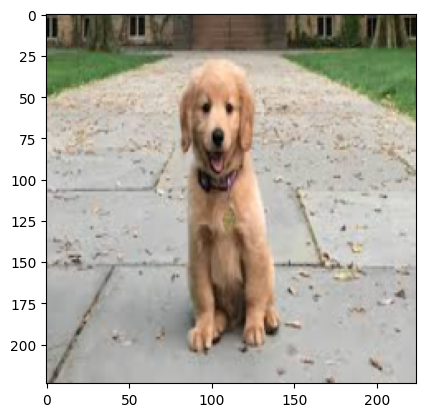

In [9]:
#plot the 'image' tensor
plt.imshow((image.permute(1, 2, 0))*0.5 + 0.5)
plt.show()

In [10]:
# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

In [11]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 5e-05
    maximize: False
    weight_decay: 0.01
)

In [12]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [13]:
# Training loop
num_epochs = 20
train_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}")

Epoch 1/20, Training Loss: 1.0150
Epoch 2/20, Training Loss: 0.3799
Epoch 3/20, Training Loss: 0.1393
Epoch 4/20, Training Loss: 0.0511
Epoch 5/20, Training Loss: 0.0224
Epoch 6/20, Training Loss: 0.0118
Epoch 7/20, Training Loss: 0.0072
Epoch 8/20, Training Loss: 0.0049
Epoch 9/20, Training Loss: 0.0037
Epoch 10/20, Training Loss: 0.0029
Epoch 11/20, Training Loss: 0.0023
Epoch 12/20, Training Loss: 0.0019
Epoch 13/20, Training Loss: 0.0016
Epoch 14/20, Training Loss: 0.0013
Epoch 15/20, Training Loss: 0.0011
Epoch 16/20, Training Loss: 0.0010
Epoch 17/20, Training Loss: 0.0008
Epoch 18/20, Training Loss: 0.0008
Epoch 19/20, Training Loss: 0.0007
Epoch 20/20, Training Loss: 0.0006


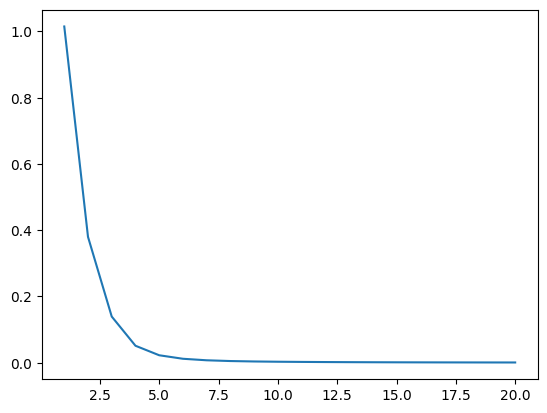

In [14]:
import matplotlib.pyplot as plt

plt.plot(range(1,21), train_losses)
plt.show()

In [15]:
# Validation loop
model.eval()
correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / len(val_loader.dataset)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 1.0000


In [16]:
labels

tensor([0, 1])

In [17]:
torch.max(outputs, 1)[1]

tensor([0, 1])

In [18]:
torch.max(outputs, 1)[0]

tensor([0.8882, 1.5220])

In [19]:
# Classification report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=['Dog', 'Cat']))


Classification Report:

              precision    recall  f1-score   support

         Dog       1.00      1.00      1.00         1
         Cat       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



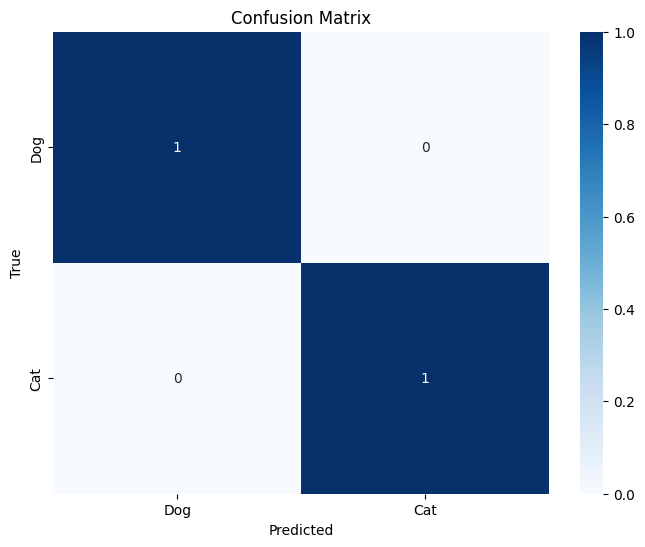

In [20]:
# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

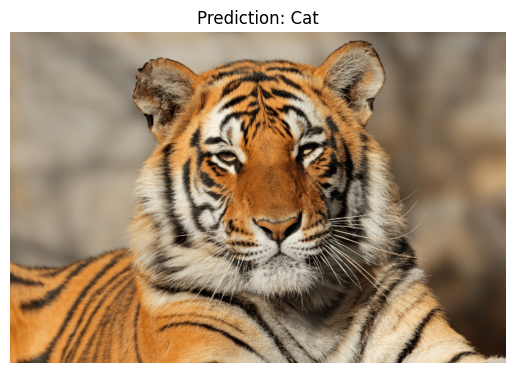

In [114]:
def predict(image_path):
    if type(image_path) == str:
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0)
        image = image.to(device)
    else:
        image = image_path
    model.eval()

    with torch.no_grad():
        output = model(image).logits
        _, pred = torch.max(output, 1)

    return pred.item()

# Display the image and prediction
image_path = "dataset/tiger.png"
pred = predict('dataset/tiger.png')
plt.imshow(plt.imread(image_path))
plt.axis("off")
plt.title(f"Prediction: {classes[pred]}")
plt.show()

# XAI Lime

In [23]:
from lime import lime_image

In [102]:
# Ensure model is in evaluation mode
model.eval()

def predicts(images):
    images = torch.from_numpy(images).float().to(device)  
    images = images.permute(0, 3, 1, 2)  
    logits = model(images).logits
    probs = torch.nn.functional.softmax(logits, dim=1).detach().cpu().numpy() 
    return probs

In [123]:
def apply_lime(img, label):
    lime_explainer = lime_image.LimeImageExplainer()

    explanation = lime_explainer.explain_instance(
        img.numpy(),
        predicts,
        top_labels=1, 
        hide_color=0, 
        num_samples=1000
    )

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, negative_only=False, num_features=5, hide_rest=True)

    dict_heatmap = dict(explanation.local_exp[explanation.top_labels[0]])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

    plt.figure(figsize=(14, 8))
    plt.subplot(1, 2, 1)  
    plt.imshow(img*0.5 + 0.5)
    plt.title(f'Original Image \n Ground Truth:{"Flooded" if label == 1 else "Non-Flooded"}')

    plt.subplot(1, 2, 2)
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.title(f'Heatmap \n Predicted: {classes[predict(img.permute(2, 0, 1).unsqueeze(0))]}')
    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

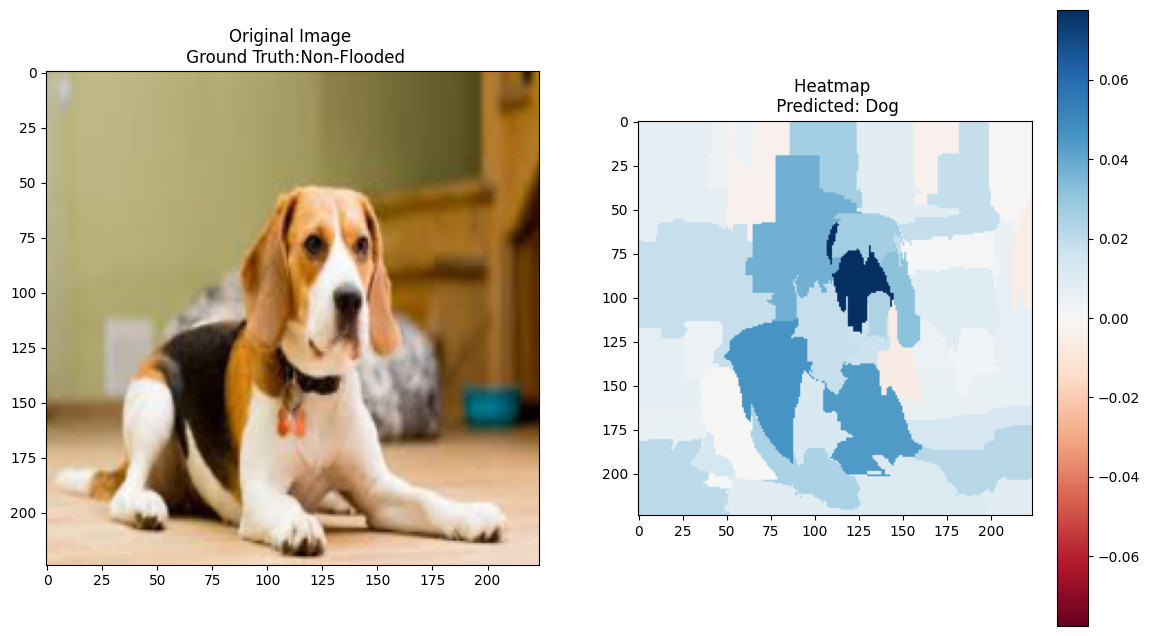

In [124]:
index = 0
img = train_loader.dataset[index][0].unsqueeze(0)[0].permute(1, 2, 0)
label = train_loader.dataset[index][1]

apply_lime(img, label)

  0%|          | 0/1000 [00:00<?, ?it/s]

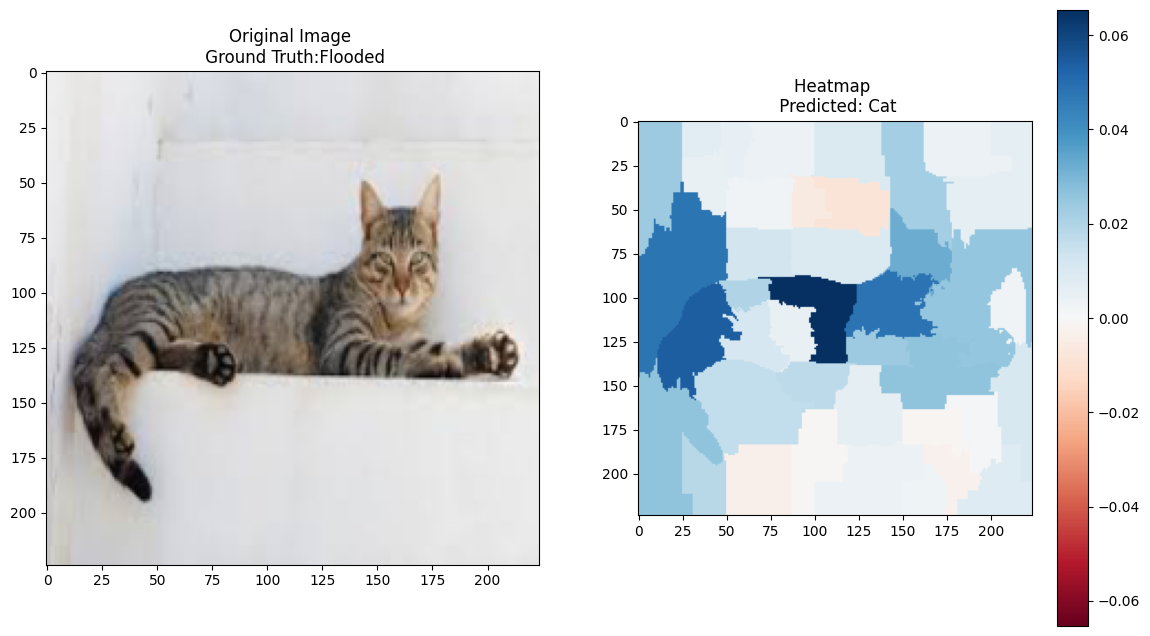

In [125]:
index = 3
img = train_loader.dataset[index][0].unsqueeze(0)[0].permute(1, 2, 0)
label = train_loader.dataset[index][1]

apply_lime(img, label)